# Advanced Text Generation and Comparison with RNNs and Transformers

## 1. Initial Environment Setup and Configuration

In [1]:
!pip install keras-tuner tensorflow numpy pandas -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import os
import pipeline
import plotter
import numpy as np
import tuner
import trainer

gpus = tf.config.list_physical_devices('GPU')

if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy()
    print(f"Detected {strategy.num_replicas_in_sync} GPUs. Using MirroredStrategy.")
    print(f"Multi-GPU training is now enabled.")
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print("--- Single GPU Detected ---")
else:
    strategy = tf.distribute.get_strategy()
    print("No GPU Detected. Training will be slow.")

# Memory Growth for MirroredStrategy
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

--- Single GPU Detected ---


In [3]:
print("Files in current directory:", os.listdir('.'))
if 'models' in os.listdir('.'):
    print("Models directory:", os.listdir('models'))

Files in current directory: ['.config', '.ipynb_checkpoints', '__pycache__', 'abcnews-date-text.csv', 'tokenizer.py', 'Untitled0.ipynb', 'trainer.py', 'metrics.py', 'dataset_loader.py', 'plotter.py', 'tuner.py', 'models', 'data_preparation.py', 'pipeline.py', 'sample_data']
Models directory: ['__pycache__', 'transformer_model.py', 'lstm_model.py', 'gru_model.py']


In [4]:
# I got the best results with batch size 1048 per GPU
per_replica_batch_size = 1048
global_batch_size = per_replica_batch_size * strategy.num_replicas_in_sync

In [5]:
# Central configuration dictionary to manage the project
CONFIG = {
    "data_file": "abcnews-date-text.csv",
    "sample_size": 200000,
    "tokenizer_path": "bpe-tokenizer.json",
    "vocab_size": 10000,
    "max_len": 50,
    "batch_size": global_batch_size,
    "final_training_epochs": 20,
    "models_to_run": ['lstm', 'gru', 'transformer']
}

## 2. Triggering Data Load, Preprocess and Preparation Pipeline and BPE Tokenizer Training

In [6]:
# Preparing training and validating datasets and training a BPE Tokenizer
train_dataset, val_dataset, vocab_size, max_len = pipeline.run_data_pipeline(CONFIG)
print(f"\nData successfully prepared.")


STARTING DATA PIPELINE EXECUTION...

Starting Data Loading and Cleaning...
Dataset loaded successfully from abcnews-date-text.csv. Original shape: (1244184, 2)
Loaded 1244184 headlines.
Using a sample of 200000 headlines for the corpus.

DataCleaning Complete.
Sample of the cleaned corpus:
aba decides against community broadcasting licence act fire witnesses must be aware of defamation a g calls for infrastructure protection summit air nz staff in aust strike for pay rise air nz strike to affect australian travellers ambitious olsson wins triple jump antic delighted with record breaking barca aussie qualifier stosur wastes four memphis match aust addresses un security council over iraq australia is locked into war timetable opp australia to contribute million in aid to iraq barca 
--- Starting BPE Tokenizer Training with vocab size 10000 ---
Tokenizer trained and saved to bpe-tokenizer.json

Starting Data Preparation for TF Dataset Pipeline...
Created 1402059 sequences.

TF Dataset pi

## 3. Tuning for best Hyperparameters and Model Training

In [7]:
# Final training results
training_results = {}

# Begin for each model
for model_name in CONFIG['models_to_run']:

    # Finds the best hyperparameters using tuner module
    best_hps = tuner.find_best_hyperparameters(
        strategy,
        model_name,
        train_ds=train_dataset,
        val_ds=val_dataset,
        vocab_size=vocab_size,
        max_len=max_len
    )

    print(f"\nCongrats! Best Hyperparameters found for {model_name.upper()}:")
    print(best_hps.values)

    # Trains the model one last time using the optimal hyperparameters
    training_results[model_name] = trainer.train_model(
        strategy,
        model_name,
        best_hps,
        train_ds=train_dataset,
        val_ds=val_dataset,
        vocab_size=vocab_size,
        max_len=max_len,
        epochs=CONFIG['final_training_epochs']
    )

print("\nTuning and Training Phase Completed.")

Trial 3 Complete [00h 05m 02s]
val_perplexity: 1287.0638427734375

Best val_perplexity So Far: 1090.8426513671875
Total elapsed time: 00h 15m 21s

--- Tuning Complete for TRANSFORMER ---
Optimal Embedding Dim: 96
Optimal Learning Rate: 0.01

Congrats! Best Hyperparameters found for TRANSFORMER:
{'embedding_dim': 96, 'num_heads': 4, 'ff_dim': 192, 'dropout_rate': 0.2, 'learning_rate': 0.01}

--- Starting Final Training for TRANSFORMER ---
Epoch 1/20
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 84s 71ms/step - accuracy: 0.0324 - loss: 7.9303 - perplexity: 2846.9023 - val_accuracy: 0.0358 - val_loss: 7.8277 - val_perplexity: 2516.4089
Epoch 2/20
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 66s 62ms/step - accuracy: 0.0404 - loss: 7.5670 - perplexity: 1945.9695 - val_accuracy: 0.0498 - val_loss: 7.4349 - val_perplexity: 1699.5363
Epoch 3/20
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 65s 60ms/step - accuracy: 0.0536 - loss: 7.2433 - perplexity: 1404.0322 - val_accuracy: 0.0604 - val_loss: 7.3094 - val_perplexity: 1499.3372
Epoch 

## 4. Evaluation Metrics and Visualization

Plotting training and validation loss...



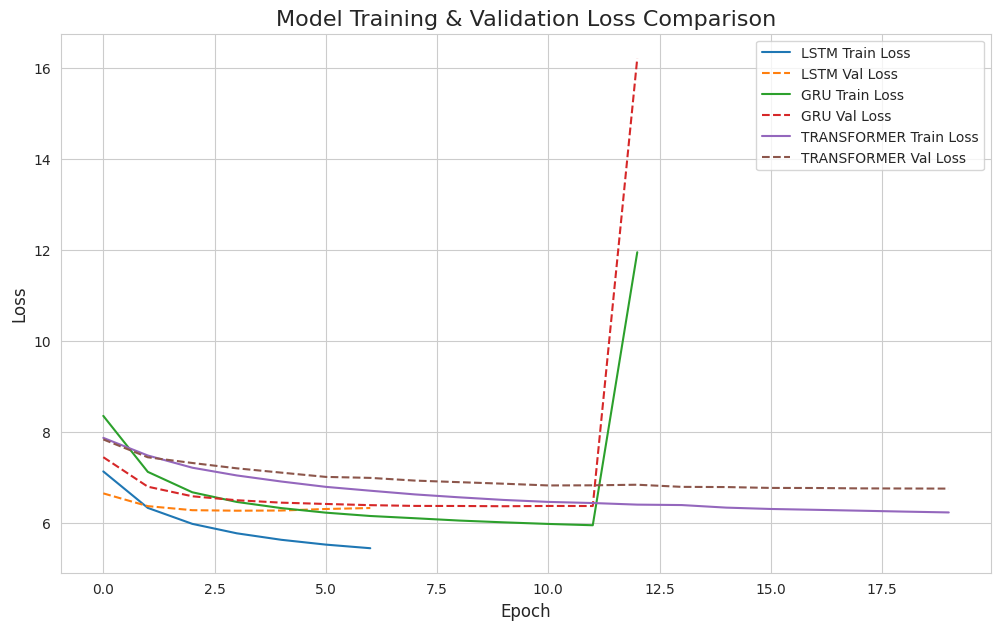


Plotting training and validation accuracy...



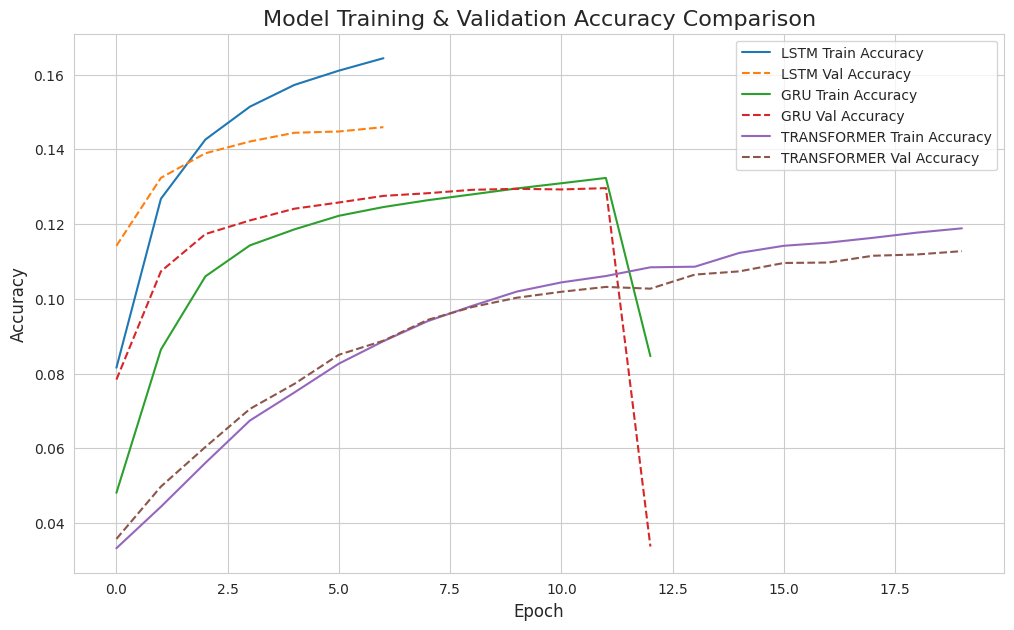


Plotting training and validation perplexity...



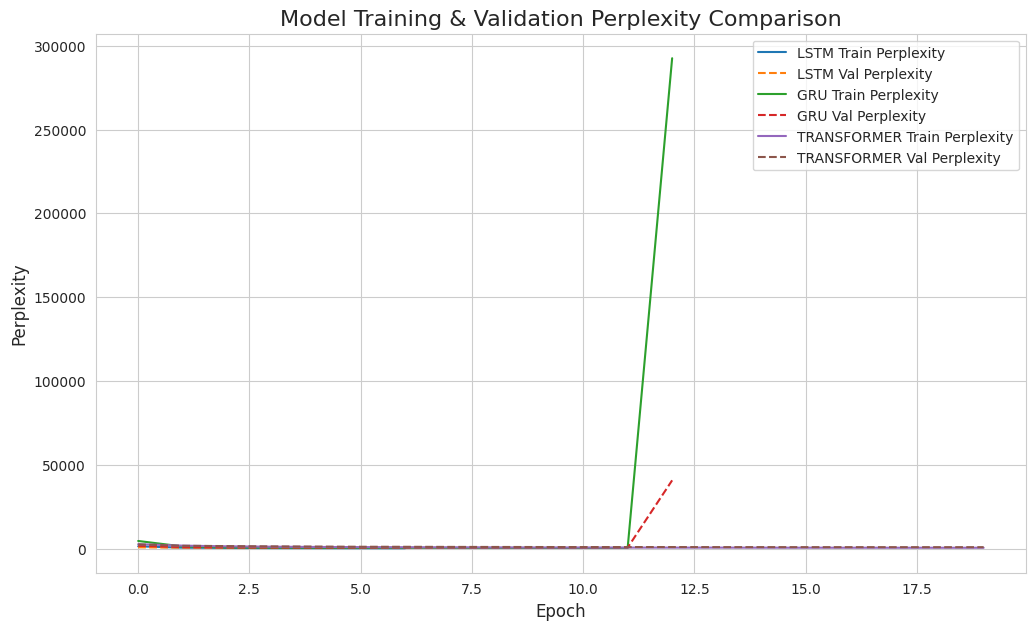

In [8]:
print("Plotting training and validation loss...\n")
plotter.plot_training_histories(training_results, metric='loss')

print("\nPlotting training and validation accuracy...\n")
plotter.plot_training_histories(training_results, metric='accuracy')

print("\nPlotting training and validation perplexity...\n")
plotter.plot_training_histories(training_results, metric='perplexity')

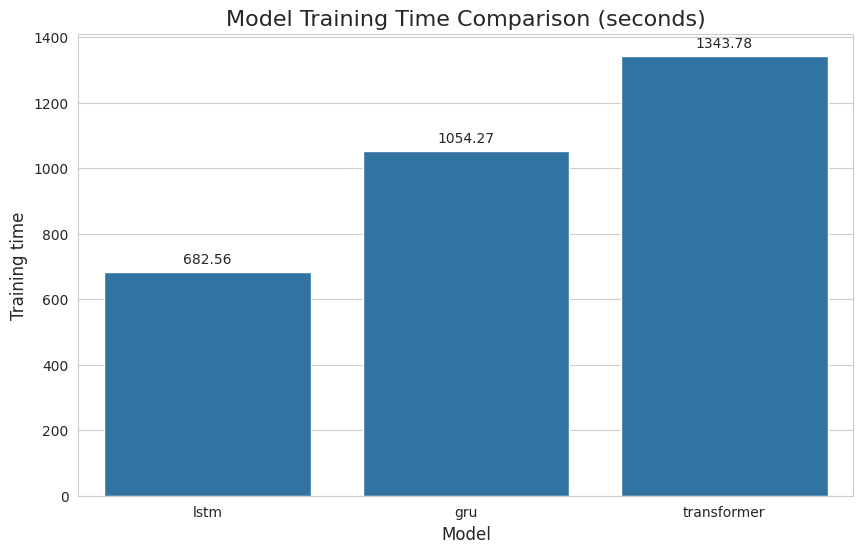

In [9]:
plotter.plot_comparison_chart(
    training_results,
    'training_time',
    'Model Training Time Comparison (seconds)'
)

## 5. Language Modeling with trained models - Next Word Prediction

In [10]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tokenizer import load_tokenizer
from metrics import perplexity
from models.transformer_model import TransformerBlock, TokenAndPositionEmbedding

def generate_text(model, tokenizer, seed_text, max_sequence_len, num_words_to_generate):
    """Generates text from a trained model."""
    output_text = seed_text

    for _ in range(num_words_to_generate):
        token_list = tokenizer.encode(output_text).ids
        padded_sequence = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(padded_sequence, verbose=0)
        predicted_id = np.argmax(predicted_probs, axis=-1)[0]
        output_word = tokenizer.decode([predicted_id])
        output_text += " " + output_word

    return output_text

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from metrics import perplexity

from models.transformer_model import TokenAndPositionEmbedding, TransformerBlock

def safe_load_TPE(config):
    valid_args = ['maxlen', 'vocab_size', 'embed_dim']
    filtered_config = {k: v for k, v in config.items() if k in valid_args}
    return TokenAndPositionEmbedding(**filtered_config)

def safe_load_TB(config):
    valid_args = ['embed_dim', 'num_heads', 'ff_dim', 'rate']
    filtered_config = {k: v for k, v in config.items() if k in valid_args}
    return TransformerBlock(**filtered_config)

class PerplexityMetric(tf.keras.metrics.Metric):
    def __init__(self, name='perplexity', **kwargs):
        super().__init__(name=name, **kwargs)
        self.cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
        self.total_loss = self.add_weight(name='total_loss', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        loss = self.cross_entropy(y_true, y_pred)
        self.total_loss.assign_add(tf.reduce_sum(loss))
        self.count.assign_add(tf.cast(tf.size(y_true), dtype=tf.float32))

    def result(self):
        mean_loss = self.total_loss / self.count
        return tf.exp(mean_loss)

    def reset_state(self):
        self.total_loss.assign(0.)
        self.count.assign(0.)

custom_objects = {
    'TokenAndPositionEmbedding': safe_load_TPE,
    'TransformerBlock': safe_load_TB,
    'perplexity': PerplexityMetric
}

seed_text = "And God said"
num_words = 10

for model_name in CONFIG['models_to_run']:
    print(f"\n--- Generating text with {model_name.upper()} ---")

    model_path = training_results[model_name]['model_path']

    model = load_model(model_path, custom_objects=custom_objects)

    generated_headline = generate_text(model, tokenizer, seed_text, max_len, num_words)

    print(f"Seed: '{seed_text}'")
    print(f"Generated: '{generated_headline}'")

### Thank You!